<h1 id="Netflix" style="color:white;background:#0076a8;padding:8px;border-radius:8px"> Netflix Appetency - Identify consumer willing to subscribe </h1>

<center><img src="https://play-lh.googleusercontent.com/0rgPYj0GwZ6txpYZrzoMdhwzqg7vY6C9B-Ol7jlaz-Ox2rgpD4Tr82ZgDqkirrEohbGm"></center>

<h2>Goal:</h2>
    
Classify consumers according to their appetite to subscribe to Netflix.

<h2>Metric:</h2>

The metric used is AUC

<h2>Data:</h2>

* train.csv - the training set. it consists of an id column, the customers features, and a target column: target.
* test.csv - the test set. it consists of everything in train.csv except target.
* sample_submission.csv - a sample submission file in the correct format target=1 means that the customer subscribes to Netflix

For reasons of confidentiality, the data is anonymized and augmented.


<h1 id="import" style="color:white;background:#0076a8;padding:8px;border-radius:8px">Import libraries</h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold,StratifiedKFold,cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')
sns.set()

<h1 id="reading" style="color:white;background:#0076a8;padding:8px;border-radius:8px">Reading datasets</h1>

In [2]:
train=pd.read_csv('../input/netflix-appetency/train.csv')
test=pd.read_csv('../input/netflix-appetency/test.csv')
sample=pd.read_csv('../input/netflix-appetency/sample_submission.csv')

In [3]:
train.shape, test.shape

((70000, 509), (30000, 508))

### Describe

In [4]:
#Describe
train.describe()

,id,target,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,...,feature_497,feature_498,feature_499,feature_500,feature_501,feature_502,feature_503,feature_504,feature_505,feature_506
count,70000.000000,70000.000000,25424.000000,26389.000000,27792.000000,25424.000000,26389.000000,27792.000000,25424.000000,26389.000000,...,70000.000000,70000.0,70000.000000,70000.0,70000.000000,70000.0,70000.000000,70000.000000,70000.0,70000.000000
mean,50025.281314,0.298186,40.124969,39.975888,38.937569,32.120109,31.533970,30.517150,2.891956,2.847829,...,-3.138300,0.0,-3.138300,0.0,3.138300,0.0,3.138300,-3.138300,0.0,3.138300
std,28878.675532,0.457465,21.415242,20.591512,20.364727,13.766195,13.330736,13.692785,2.294987,2.267976,...,17.344944,0.0,17.344944,0.0,17.344944,0.0,17.344944,17.344944,0.0,17.344944
min,0.000000,0.000000,-217.460000,-89.690000,-66.497000,-219.180000,-89.690000,-49.390000,-30.850000,-19.813333,...,-99.000000,0.0,-99.000000,0.0,0.000000,0.0,0.000000,-99.000000,0.0,0.000000
25%,24999.750000,0.000000,32.470000,32.470000,31.923333,30.750000,28.600000,27.215000,2.500000,2.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
50%,50030.500000,0.000000,37.480000,37.560000,37.030667,34.160000,33.320000,31.710000,2.500000,2.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
75%,75027.250000,1.000000,48.062750,48.490000,47.726458,35.830000,35.830000,35.830000,2.500000,2.500000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
max,99999.000000,1.000000,403.880000,639.756667,511.091667,148.360000,136.030000,136.030000,47.000000,53.556667,...,0.000000,0.0,0.000000,0.0,99.000000,0.0,99.000000,0.000000,0.0,99.000000


<h1 id="missings" style="color:white;background:#0076a8;padding:8px;border-radius:8px"> Missing values </h1>

In [5]:
def get_missings(df):
    labels,values = list(),list()
    if df.isna().sum().sum()>0:
        for column in df.columns:
            if df[column].isnull().sum():
                labels.append(column)
                values.append((df[column].isnull().sum() / len(df[column]))*100)
        missings=pd.DataFrame({'Feature':labels,'MissingPercent':values }).sort_values(by='MissingPercent',ascending=False)
        return missings
    else:
        return False

In [6]:
#Missing values report
Missings_df=get_missings(train)
Missings_df.head(10)

,Feature,MissingPercent
52,feature_193,100.000000
55,feature_196,100.000000
56,feature_197,100.000000
57,feature_198,100.000000
21,feature_83,98.320000
18,feature_75,70.297143
19,feature_76,70.297143
54,feature_195,63.890000
0,feature_5,63.680000
3,feature_8,63.680000


## Distribution of missing values

Text(0, 0.5, 'The number of features')

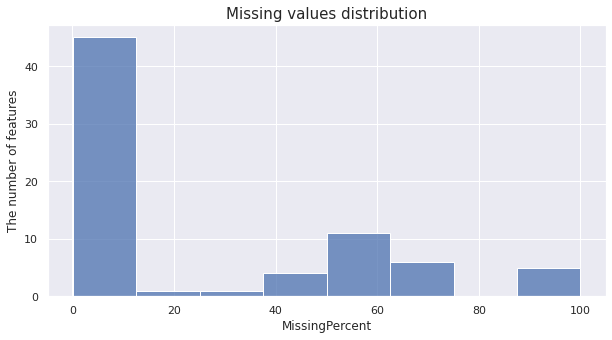

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(x=Missings_df.MissingPercent).set_title('Missing values distribution',size=15)
plt.ylabel('The number of features')

<h2> Drop features with more than 25% missing values </h2>

In [8]:
#Get columns with more than 30% missing values
Missings_custom=Missings_df[Missings_df.MissingPercent>25]
#Drop from train and test 
train=train.drop(list(Missings_custom.Feature),axis=1)
test=test.drop(list(Missings_custom.Feature),axis=1)

<h2> Numeric and categorical features</h2>

In [9]:
#Categorical features name
Categorical_Features=train.select_dtypes(include=['object']).columns
        
#Numeric features name
Numeric_Features=train.select_dtypes(exclude=['object']).columns[2:] #skip id,target

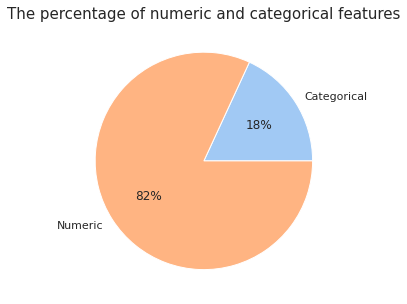

In [10]:
#Pichart
data = [len(Categorical_Features),len(Numeric_Features)]
colors = sns.color_palette('pastel')
plt.figure(figsize=(10,5))
plt.title('The percentage of numeric and categorical features',size=15)
plt.pie(data, colors = colors, labels=['Categorical','Numeric'] ,autopct = '%0.0f%%')
plt.show()

<h2> Filling missing values </h2>

<h3> Numeric features </h3>

In [11]:
#Fill with median
for col in Numeric_Features:
    train[col].fillna(train[col].median(),inplace=True)
    test[col].fillna(test[col].median(),inplace=True)

<h3> Categorical features </h3>

In [12]:
#Fill with mode
def get_mode(feature,df):
    return df[feature].mode()[0]

for col in Categorical_Features:
    train[col].fillna(get_mode(col,train),inplace=True)
    test[col].fillna(get_mode(col,test),inplace=True)

<h2> Information about dataset </h2>

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 482 entries, id to feature_506
dtypes: float64(121), int64(274), object(87)
memory usage: 257.4+ MB


<h1 id="date" style="color:white;background:#0076a8;padding:8px;border-radius:8px">Are there DateTime features ?</h1>
I'll check first 10 rows of dataset to see if there are features that contatin dates with string/object data type, then I'll apply DateTime format

In [14]:
#Find columns that contain date objects
mask = train[Categorical_Features][:10].astype(str).apply(lambda x : x.str.match('(\d{2,4}(-|\/|\\|\.| )\d{2}(-|\/|\\|\.| )\d{2,4})+').any())
datetime_Features=train[Categorical_Features].loc[:,mask]

datetime_Features

,feature_191,feature_192,feature_199,feature_200,feature_201
0,11/10/2017,11/10/2017,11/10/2017,17/01/2016,11/10/2017
1,25/03/2015,25/03/2015,02/04/2017,25/03/2015,25/03/2015
2,27/01/2015,27/01/2015,24/03/2016,27/01/2015,27/01/2015
3,05/02/2014,01/04/2014,01/04/2014,01/04/2014,01/04/2014
4,20/07/2009,10/09/2013,10/09/2013,24/01/2016,10/09/2013
...,...,...,...,...,...
69995,27/09/2010,01/02/2014,01/02/2014,14/02/2014,01/02/2014
69996,19/09/2016,19/09/2016,19/09/2016,19/09/2016,19/09/2016
69997,14/09/2005,25/07/2015,25/07/2015,09/04/2016,25/07/2015
69998,29/11/2017,29/11/2017,29/11/2017,17/01/2016,29/11/2017


<h2> Apply DateTime format </h2>

In [15]:
#Apply datetime format
train[datetime_Features.columns]= train[datetime_Features.columns].apply(pd.to_datetime,dayfirst=False)
test[datetime_Features.columns]= test[datetime_Features.columns].apply(pd.to_datetime,dayfirst=False)

#Show datetime features
datetime_tmp=train.select_dtypes(include=['datetime'])
datetime_tmp

,feature_191,feature_192,feature_199,feature_200,feature_201
0,2017-11-10,2017-11-10,2017-11-10,2016-01-17,2017-11-10
1,2015-03-25,2015-03-25,2017-02-04,2015-03-25,2015-03-25
2,2015-01-27,2015-01-27,2016-03-24,2015-01-27,2015-01-27
3,2014-05-02,2014-01-04,2014-01-04,2014-01-04,2014-01-04
4,2009-07-20,2013-10-09,2013-10-09,2016-01-24,2013-10-09
...,...,...,...,...,...
69995,2010-09-27,2014-01-02,2014-01-02,2014-02-14,2014-01-02
69996,2016-09-19,2016-09-19,2016-09-19,2016-09-19,2016-09-19
69997,2005-09-14,2015-07-25,2015-07-25,2016-09-04,2015-07-25
69998,2017-11-29,2017-11-29,2017-11-29,2016-01-17,2017-11-29


<h2> Separating Year, Month,Week and Day </h2>

In [16]:
#get each part of datetime using pandas DatetimeIndex
for col in datetime_tmp.columns:
    train[col+"_year"]=pd.DatetimeIndex(train[col]).year
   # train[col+"_month"]=pd.DatetimeIndex(train[col]).month
  # train[col+"_week"]=pd.DatetimeIndex(train[col]).week
   # train[col+"_day"]=pd.DatetimeIndex(train[col]).day

    
    test[col+"_year"]=pd.DatetimeIndex(test[col]).year
   # test[col+"_month"]=pd.DatetimeIndex(test[col]).month
   # test[col+"_week"]=pd.DatetimeIndex(test[col]).week
   # test[col+"_day"]=pd.DatetimeIndex(test[col]).day

<h2> Drop datetime features </h2>

In [17]:
#Drop from train/test
train.drop(list(datetime_tmp.columns),axis=1,inplace=True)
test.drop(list(datetime_tmp.columns),axis=1,inplace=True)

#Update Categorical_Features list
Categorical_Features = [e for e in Categorical_Features
                        if e not in datetime_tmp.columns]

In [18]:
#Create a copy of datasets
train_c=train.copy()
test_c=test.copy()

<h1 id="cardinality" style="color:white;background:#0076a8;padding:8px;border-radius:8px">  Cardinality of categorical features </h1>

The function below calculates the number of unique values for each categorical feature and returns a data frame

In [19]:
#Get the number of unique values for each feature
def get_high_cardinality(df,ftype):
    tmp=[]
    for col in ftype:
        tmp.append( df[col].nunique() )

    High_cardinality=pd.DataFrame({'Features':ftype,'Cardinality':tmp})
    return High_cardinality.sort_values(by='Cardinality',ascending=False)

In [20]:
#Categorical Features Sorted by cardinality 
cardinality=get_high_cardinality(train_c,Categorical_Features).head(10)
cardinality

,Features,Cardinality
7,feature_18,15858
28,feature_133,7126
9,feature_20,5841
11,feature_22,2339
10,feature_21,2327
8,feature_19,260
24,feature_54,260
35,feature_185,255
48,feature_246,147
63,feature_279,136


### 'feature_18' has 7181 categories with 1 value count:

In [21]:
train_c['feature_18'].value_counts()[train_c['feature_18'].value_counts()<2]

C21571    1
C18763    1
C7904     1
C7468     1
C25958    1
         ..
C10695    1
C23750    1
C14000    1
C11838    1
C22264    1
Name: feature_18, Length: 7181, dtype: int64

<h2> Reducing cardinality of categorical features </h2>

Categories with one value count will be replaced with the 'other'

In [22]:
for col in list(get_high_cardinality(train_c,Categorical_Features).Features):
        #get a list of categories which contain one value
        tmp=list(train_c[col].value_counts()[train_c[col].value_counts()<2].index)
        #Replace with 'other'
        train_c[col]=train_c[col].apply(lambda x:'other' if x in tmp else x)

#Do the same for test dataset    
for col in list(get_high_cardinality(test_c,Categorical_Features).Features):
        tmp=list(test_c[col].value_counts()[test_c[col].value_counts()<2].index)
        test_c[col]=test_c[col].apply(lambda x:'other' if x in tmp else x)

<h1 id="missings" style="color:white;background:#0076a8;padding:8px;border-radius:8px">  Chi-Square Test of independence for categorical features </h1>

<h3> p-value level = 0.05 </h3>

<h3> Null Hypothesis (H0): There is no relationship between feature and target </h3>

In [23]:
# Import the chi-square 
from scipy.stats import chi2_contingency

chi2_check = []
for i in Categorical_Features:
    if chi2_contingency(pd.crosstab(train['target'], train[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [Categorical_Features, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
res

,Column,Hypothesis
0,feature_0,Fail to Reject Null Hypothesis
1,feature_1,Fail to Reject Null Hypothesis
2,feature_2,Reject Null Hypothesis
3,feature_3,Reject Null Hypothesis
4,feature_4,Reject Null Hypothesis
...,...,...
77,feature_293,Reject Null Hypothesis
78,feature_336,Reject Null Hypothesis
79,feature_337,Fail to Reject Null Hypothesis
80,feature_338,Fail to Reject Null Hypothesis


<h3> Add those features to drop list which failed to reject Null Hypothesis </h3>
I'll create a drop list to add unwanted features into it 

In [24]:
#add unwanted categorical features to drop list
Unwanted_catFeatures= res[res.Hypothesis=='Fail to Reject Null Hypothesis'].Column

#Add to Drop list
Features_toDrop=[]
Features_toDrop+=list(Unwanted_catFeatures)
print(len(Unwanted_catFeatures),' features added to drop list')

17  features added to drop list


<h1 id="Working" style="color:white;background:#0076a8;padding:8px;border-radius:8px">  Working with numeric features </h1>

## Correlations

<h3>Correlation between numeric features and the target</h3>


In [25]:
#Get correlations with target (sorted)
corr_df=train_c.drop(['target'],axis=1).corrwith(train_c['target']).abs().sort_values(ascending=False)

Text(0.5, 0, 'Correlation')

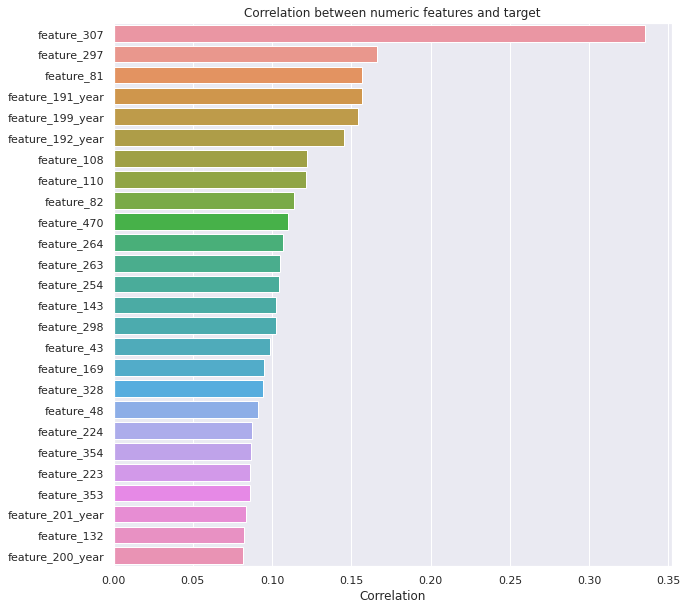

In [26]:
#Plot features which have more than 0.08 correlation with the target
plt.figure(figsize=(10,10))

#Plot - sorted correlations
sns.barplot(x=corr_df[corr_df>0.08],y=corr_df[corr_df>0.08].index).set_title('Correlation between numeric features and target')
plt.xlabel('Correlation')

### Distribution 

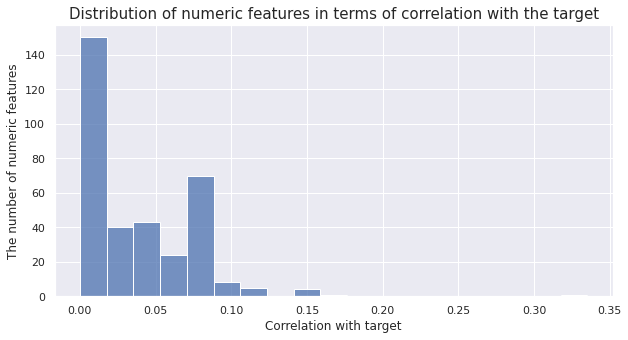

In [27]:
plt.figure(figsize=(10,5))
plt.xlabel('Correlation with target')
plt.ylabel('The number of numeric features')
sns.histplot(corr_df).set_title('Distribution of numeric features in terms of correlation with the target',size=15)
plt.show()

As we can see the correlation between most numeric features and the target is not significant, There is only 1 numeric feature which has correlation more than 0.3 with the target and it's binary feature just like the target

### Visualize

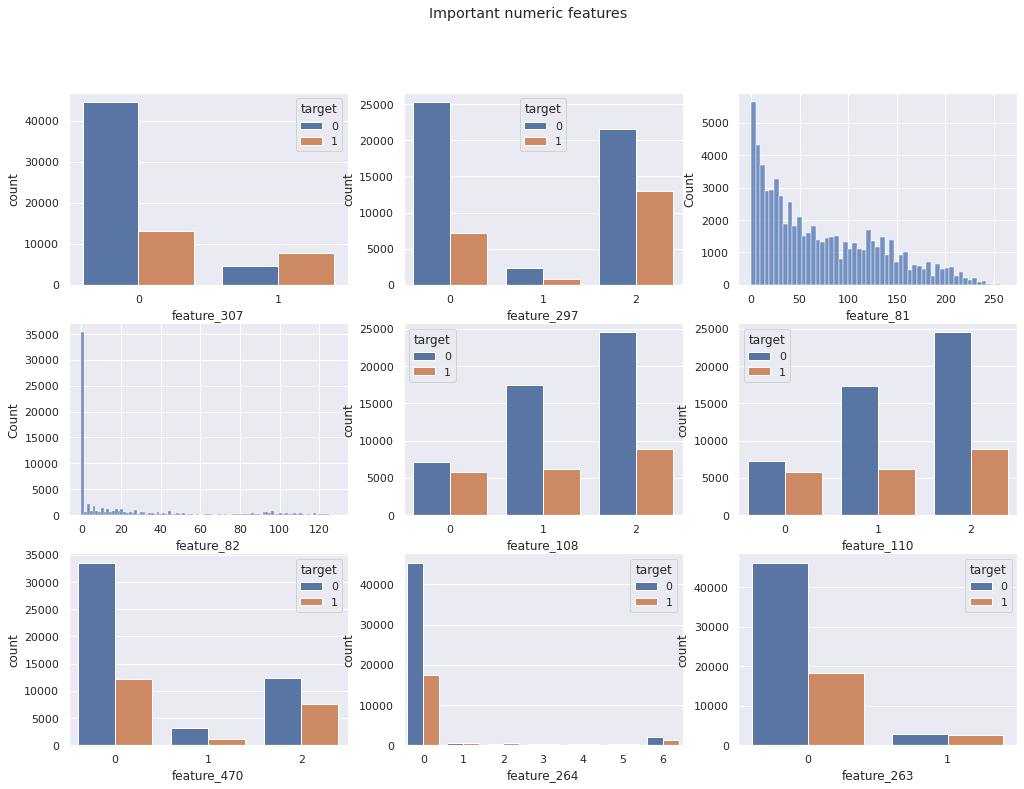

In [28]:
fig, ax = plt.subplots(3,3,figsize=(17,12))
sns.countplot(train_c.feature_307,hue=train_c.target, ax=ax[0][0])
sns.countplot(train_c.feature_297,hue=train_c.target, ax=ax[0][1])
sns.histplot(train_c.feature_81, ax=ax[0][2])
sns.histplot(train_c.feature_82, ax=ax[1][0])
sns.countplot(train_c.feature_108,hue=train_c.target, ax=ax[1][1])
sns.countplot(train_c.feature_110,hue=train_c.target, ax=ax[1][2])
sns.countplot(train_c.feature_470,hue=train_c.target, ax=ax[2][0])
sns.countplot(train_c.feature_264,hue=train_c.target, ax=ax[2][1])
sns.countplot(train_c.feature_263,hue=train_c.target, ax=ax[2][2])

plt.suptitle('Important numeric features')
plt.show()

### Add new features

In [29]:
#Taking sqrt of feature_81
train_c['feature_81_sqrt']= train_c.feature_81.apply(np.sqrt)
test_c['feature_81_sqrt']= test_c.feature_81.apply(np.sqrt)

#Binarization feature_82
train_c['feature_82_binary']= train_c['feature_82'].apply(lambda x: 0 if x==0 else 1)
test_c['feature_82_binary']= test_c['feature_82'].apply(lambda x: 0 if x==0 else 1)

#Multiplication of feature_307 and feature_82_binary
train_c['feature_82_307']= train_c['feature_307']*train_c['feature_82_binary']
test_c['feature_82_307']= test_c['feature_307']*test_c['feature_82_binary']

### Add features to drop list that have insignificant correlation with target

In [30]:
#Corr less than 0.002 with target
low_corr=list(corr_df[corr_df<0.002].index)

#Add to drop list
Features_toDrop+=low_corr
print(len(low_corr),' features added to drop list')

28  features added to drop list


## Features with one unique value 

In [31]:
tmp=[]
for col in train_c.columns:
    #If column contains one unique value
    if (( train_c[col].nunique() <=1 )):
        #add to list
        tmp.append(col)
#Filter dataframe
train[tmp]

,feature_55,feature_100,feature_149,feature_187,feature_188,feature_190,feature_227,feature_228,feature_248,feature_249,...,feature_484,feature_487,feature_489,feature_491,feature_493,feature_495,feature_498,feature_500,feature_502,feature_505
0,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
1,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
2,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
3,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
4,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
69996,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
69997,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0
69998,C0,0,0,C0,C0,C0,0,0,C0,C1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Add to drop list
Features_toDrop+=list(tmp)

print(len(tmp),' features added to drop list')

59  features added to drop list


### Correlation between features

In [33]:
def get_highly_correlated(df, features, threshold=0.5):
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        col1,col2,col3=list(),list(),list()
        for v, i, j in s_corr_list:
            col1.append(corr_df.index[i])
            col2.append(corr_df.columns[j])
            col3.append(v)
        col_list=[col1,col2,col3]
        return pd.DataFrame(col_list, index=['F1', 'F2','Correlation']).T.sort_values(by='Correlation',ascending=False)

### There is more than 0.99 correlation between some features

In [34]:
F_corr_df= get_highly_correlated(train_c[Numeric_Features],Numeric_Features,threshold=0.9)
F_corr_df

,F1,F2,Correlation
0,feature_46,feature_140,1.0
520,feature_448,feature_464,1.0
511,feature_444,feature_503,1.0
513,feature_444,feature_506,1.0
514,feature_448,feature_450,1.0
...,...,...,...
447,feature_424,feature_497,-1.0
36,feature_374,feature_490,-1.0
40,feature_374,feature_497,-1.0
443,feature_424,feature_490,-1.0


### Drop one of two highly correlated features

In [35]:
#Using set() to get distinct features from the column F1
drop_F1=list( set(F_corr_df.F1[F_corr_df.Correlation>0.9]) ) + list( set(F_corr_df.F1[F_corr_df.Correlation<-0.9]) )

#Drop
Features_toDrop += drop_F1
print(len(drop_F1),' features added to drop list')

188  features added to drop list


<h1 id="drop" style="color:white;background:#0076a8;padding:8px;border-radius:8px">Drop unwanted features </h1>

Finally let's drop unwanted features that we have added into drop list so far

In [36]:
Features_toDrop=list(set(Features_toDrop))

train_c.drop(Features_toDrop,axis=1,inplace=True)
test_c.drop(Features_toDrop,axis=1,inplace=True)

#Remove from Categorical_Features list
Categorical_Features = [e for e in Categorical_Features
                        if e not in Features_toDrop]
#Remove from Numeric features list
Numeric_Features=[e for e in Numeric_Features
                  if e not in Features_toDrop]

print(len(Features_toDrop),' Features dropped')

216  Features dropped


In [37]:
train_c.shape, test_c.shape

((70000, 269), (30000, 268))

<h1 id="encode" style="color:white;background:#0076a8;padding:8px;border-radius:8px">  Encoding categorical features </h1>


In [38]:
#Create copy
train_e=train_c.copy()
test_e=test_c.copy()

for col in list(Categorical_Features):
    le = LabelEncoder()
    #fit encoder on train/test at the same time
    le.fit(pd.concat([train_e[col],test_e[col]], ignore_index=True))
    #transform 
    train_e[col]=le.transform(train_e[col])
    test_e[col]=le.transform(test_e[col])

<h1 id="encode" style="color:white;background:#0076a8;padding:8px;border-radius:8px">  Modeling </h1>

<h2> Define and split variables </h2>

In [39]:
toDrop=['target'] + ['feature_82','feature_192_year','feature_199_year','feature_200_year','feature_201_year']

#Variables
X=train_e.drop(toDrop,axis=1)
y=train_e['target']

X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size=0.2,random_state=18)

## Tuning

In [40]:
'''
import optuna
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 5000,20000,step=10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.02, 0.1),
       # "num_leaves": trial.suggest_int("num_leaves", 10, 2000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1.0, 15.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 15.0),
        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 0.1, 0.95, step=0.1),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.2, 0.95, step=0.1),
         "min_child_weight": trial.suggest_float("min_child_weight", 1, 10, step=1),
       
        #"bagging_freq": trial.suggest_int("bagging_freq", 0,10),
        #"feature_fraction": trial.suggest_float(
        #"feature_fraction", 0.2, 0.95, step=0.1
        #),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=18)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBClassifier( **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="auc",
            early_stopping_rounds=200,
            verbose=200,

        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds[:,1])

    return np.mean(cv_scores)


#Start tuning
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

#Show best parameters
print(f"\tBest auc: {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
    
'''


'\nimport optuna\nfrom optuna.integration import LightGBMPruningCallback\n\ndef objective(trial, X, y):\n    param_grid = {\n        \n        # "device_type": trial.suggest_categorical("device_type", [\'gpu\']),\n        "n_estimators": trial.suggest_int("n_estimators", 5000,20000,step=10),\n        "learning_rate": trial.suggest_loguniform("learning_rate", 0.02, 0.1),\n       # "num_leaves": trial.suggest_int("num_leaves", 10, 2000, step=20),\n        "max_depth": trial.suggest_int("max_depth", 3, 12),\n        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1.0, 15.0),\n        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 15.0),\n        \'scale_pos_weight\': trial.suggest_float("scale_pos_weight", 0.1, 0.95, step=0.1),\n        \'subsample\': trial.suggest_loguniform(\'subsample\', 0.4, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.5, 1.0),\n        "gamma": trial.suggest_float("gamma", 0.2, 0.95, step=0.1),\n         "min_child_we

## Models with tuned params

In [41]:
# Parameter grids
LGBM_params = {
    'n_estimators': 10000,
    'learning_rate': 0.01346129943895438,
    'num_leaves': 1230,
    'max_depth': 5,
    'lambda_l1': 9.014424962435049,
    'lambda_l2': 5.09941903202415,
    'min_child_samples': 56,
    'subsample': 0.8210241479916653,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.6000000000000001,
}

CATBOOST_params = {
    'subsample': 0.50,
    'learning_rate': 0.03,
    "max_depth": 6,
    "min_data_in_leaf": 50,
    "colsample_bylevel": 0.5,
    'random_state':42,
    'num_boost_round': 2000,
    'l2_leaf_reg': 1.0,
    'eval_metric': "AUC",
}

XGB_params = {
   'n_estimators': 14140,
    'learning_rate': 0.0111538499996725174,
    'max_depth': 4,
    'reg_alpha': 2.9735993984217104,
    'reg_lambda': 2.214625977393439,
    'scale_pos_weight': 0.9,
    'subsample': 0.7768428006197691,
    'gamma': 0.5
}

#LGBM
LGBM = LGBMClassifier(**LGBM_params)

#Catboost
CATBOOST = CatBoostClassifier(**CATBOOST_params)

#XGBoost
XGB = XGBClassifier(**XGB_params)

## Validation score function

In [42]:
#Returns validation score
def get_val_score(model):
    val_pred = model.predict_proba(X_valid)
    return roc_auc_score(y_valid,val_pred[:,1])

## XGBOOST Classifier

In [43]:
XGB.fit(X_train,y_train,
         eval_set=[(X_valid, y_valid)],
         early_stopping_rounds=200,verbose=100,eval_metric='auc')
#Get score
print("="*20)
print("LGBM Validation AUC : ", get_val_score(XGB))

[0]	validation_0-auc:0.74590
[100]	validation_0-auc:0.76266
[200]	validation_0-auc:0.76919
[300]	validation_0-auc:0.77427
[400]	validation_0-auc:0.77722
[500]	validation_0-auc:0.77922
[600]	validation_0-auc:0.78057
[700]	validation_0-auc:0.78152
[800]	validation_0-auc:0.78228
[900]	validation_0-auc:0.78277
[1000]	validation_0-auc:0.78317
[1100]	validation_0-auc:0.78360
[1200]	validation_0-auc:0.78390
[1300]	validation_0-auc:0.78405
[1400]	validation_0-auc:0.78433
[1500]	validation_0-auc:0.78448
[1600]	validation_0-auc:0.78467
[1700]	validation_0-auc:0.78481
[1800]	validation_0-auc:0.78491
[1900]	validation_0-auc:0.78497
[2000]	validation_0-auc:0.78504
[2100]	validation_0-auc:0.78505
[2200]	validation_0-auc:0.78516
[2300]	validation_0-auc:0.78514
[2400]	validation_0-auc:0.78509
[2418]	validation_0-auc:0.78512
LGBM Validation AUC :  0.7851942878111431


### XGBOOST feature importance

Text(0.5, 1.0, 'XGBoost Feature importance')

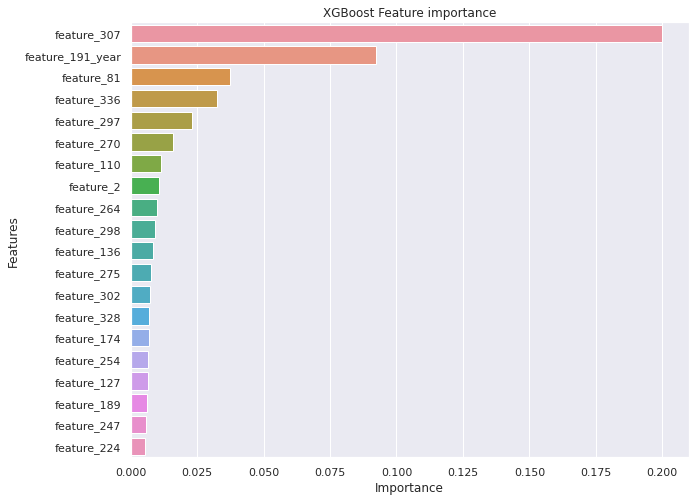

In [44]:
FI=pd.DataFrame({'Features':X.columns,'Importance':XGB.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('XGBoost Feature importance')

## LGBM Classifier

In [45]:
LGBM.fit(X_train,y_train,
         eval_set=[(X_valid, y_valid)],
         early_stopping_rounds=200,verbose=100,eval_metric='auc')
#Get score
print("="*20)
print("LGBM Validation AUC : ", get_val_score(LGBM))

[LightGBM] [Warning] lambda_l1 is set=9.014424962435049, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.014424962435049
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8210241479916653 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.09941903202415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.09941903202415
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[100]	valid_0's auc: 0.770704	valid_0's binary_logloss: 0.523377
[200]	valid_0's auc: 0.775316	valid_0's binary_logloss: 0.507379
[300]	valid_0's auc: 0.778381	valid_0's binary_logloss: 0.502333
[400]	valid_0's auc: 0.780595	valid_0's binary_logloss: 0.499819
[500]	valid_0's auc: 0.782214	valid_0's binary_logloss: 0.498199
[600]	valid_0's auc:

### LGBM Feature importance

Text(0.5, 1.0, 'LGBM Feature importance')

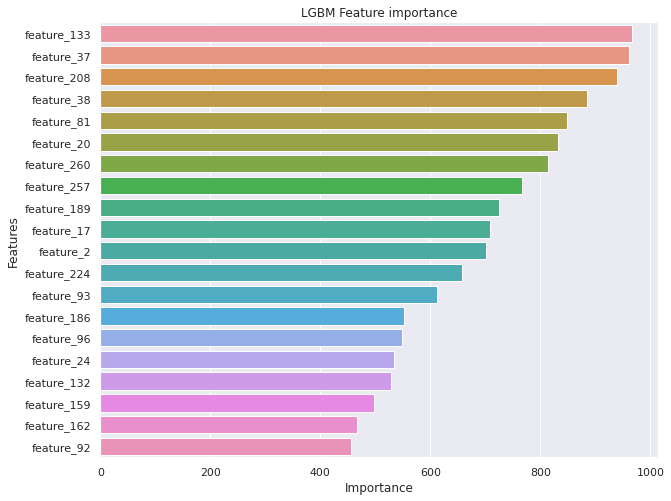

In [46]:
FI=pd.DataFrame({'Features':X.columns,'Importance':LGBM.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('LGBM Feature importance')

## CATBOOST Classifier

In [47]:
CATBOOST.fit(X_train,y_train,
             eval_set=[(X_valid, y_valid)],
             cat_features=Categorical_Features,
             early_stopping_rounds=200,verbose=100)
#Get score
print("="*20)
print("CATBOOST Validation AUC : ", get_val_score(CATBOOST))

0:	test: 0.7495993	best: 0.7495993 (0)	total: 254ms	remaining: 8m 26s
100:	test: 0.7756639	best: 0.7756639 (100)	total: 19s	remaining: 5m 56s
200:	test: 0.7799536	best: 0.7799536 (200)	total: 37.8s	remaining: 5m 38s
300:	test: 0.7814491	best: 0.7814491 (300)	total: 57.2s	remaining: 5m 22s
400:	test: 0.7826146	best: 0.7826146 (400)	total: 1m 15s	remaining: 5m 2s
500:	test: 0.7832125	best: 0.7832160 (498)	total: 1m 34s	remaining: 4m 43s
600:	test: 0.7836268	best: 0.7836323 (596)	total: 1m 53s	remaining: 4m 24s
700:	test: 0.7838774	best: 0.7838835 (690)	total: 2m 12s	remaining: 4m 6s
800:	test: 0.7841066	best: 0.7841066 (800)	total: 2m 31s	remaining: 3m 47s
900:	test: 0.7842997	best: 0.7843115 (899)	total: 2m 50s	remaining: 3m 28s
1000:	test: 0.7845609	best: 0.7845609 (1000)	total: 3m 10s	remaining: 3m 10s
1100:	test: 0.7847861	best: 0.7847861 (1100)	total: 3m 29s	remaining: 2m 51s
1200:	test: 0.7848447	best: 0.7848604 (1150)	total: 3m 49s	remaining: 2m 32s
1300:	test: 0.7849864	best: 0.7

### CatBoost Feature importance

Text(0.5, 1.0, 'CATBOOST Feature importance')

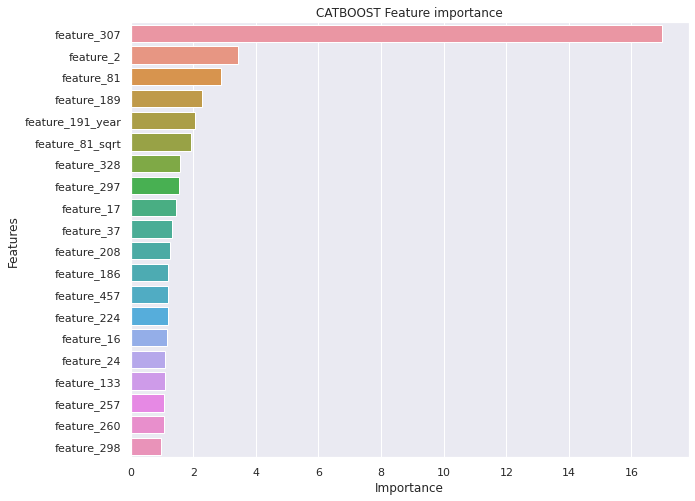

In [48]:
FI=pd.DataFrame({'Features':X.columns,'Importance':CATBOOST.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('CATBOOST Feature importance')

<h1 id="prediction" style="color:white;background:#0076a8;padding:8px;border-radius:8px"> Making prediction on test data </h1>

In [49]:
toDrop=['feature_82','feature_192_year','feature_199_year','feature_200_year','feature_201_year']

LGBM_pred=LGBM.predict_proba(test_e.drop(toDrop,axis=1))
XGB_pred=XGB.predict_proba(test_e.drop(toDrop,axis=1))
CATBOOST_pred=CATBOOST.predict_proba(test_e.drop(toDrop,axis=1))

### Ensemble of predictions

In [50]:
test_predictions = 0.4 * LGBM_pred[:,1] + 0.3 * CATBOOST_pred[:,1] + 0.3 * XGB_pred[:,1]

### Create submission file

In [51]:
sample['target']=test_predictions
sample.to_csv('submission.csv',index=False)
sample.head(10)

,id,target
0,5,0.401350
1,7,0.317016
2,9,0.310080
3,11,0.126033
4,14,0.252191
5,15,0.244366
6,19,0.127366
7,21,0.135106
8,25,0.354705
9,29,0.162790


### Credits


https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b
